## Project 3: House Price Prediction using TensorFlow Functional API
#### CSC 180 Intelligent Systems
#### Nicolas Gugliemo
## WARNING: RESTART KERNEL EACH RUN OR MODEL WILL NOT WORK. IF MODEL IS NOT LEARNING, TRY RESTARTING THE KERNEL UNTIL IT WORKS.
### Step 1: Import

In [1]:
%reset -f # Try to reset variables to fix issues
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from IPython.display import Image
from sklearn import preprocessing, metrics
from matplotlib.pyplot import figure, show
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, Embedding, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers,layers, Model, Input
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import svm, datasets
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from collections.abc import Sequence
from tensorflow.keras.utils import plot_model
from keras.preprocessing import sequence

Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  try, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  reset, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Don't know how to reset  to, please run `%reset?` for details
Don't know how to reset  fix, please run `%reset?` for details
Don't know how to reset  issues, please run `%reset?` for details


### Step 2: Functions 
### Nicolas Gugliemo

In [2]:

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        print('CLASS')
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print('REG')
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Function to plot results
def plot(results):
    fig, ax = plt.subplots(figsize=(10, 6))

    for activation in results['Activation'].unique():
        subset = results[results['Activation'] == activation]
        ax.plot(subset['Neurons'].astype(str), subset['RMSE'], marker='o', label=activation)

    ax.set_title('Model Performance by Activation Function')
    ax.set_xlabel('Layer Configuration (Neurons)')
    ax.set_ylabel('RMSE')
    ax.legend(title='Activation Function')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.show()

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    plt.plot(t['pred'].tolist(), label='Prediction', color='orange')
    plt.plot(t['y'].tolist(), label='Expected', color='blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)
    return df

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    


### Step 3: Import data and create tables 
### Nicolas Gugliemo

In [3]:
filename_read = os.path.join("data/HousesInfo.txt")
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)
df.shape


(535, 5)

### Step 4: Drop Outliers and save which indexes were dropped to match the for the img table 
### Nicolas Gugliemo

In [4]:
outlier= df.index[df['price'] <= 50000].tolist()
outlier1= df.index[df['price'] >= 900000].tolist()
outlier= outlier+outlier1
df = df.loc[(df['price'] > 50000) & (df['price'] < 900000)]
df.head()

,Bedrooms,Bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
6,3,4.0,2544,85262,799000
10,5,5.0,4829,85266,519200


### Step 5: Create Img Table
### Nicolas Gugliemo

In [5]:
## Bathroom.jpg
new_images=[]
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 
img= pd.DataFrame(new_images,columns = ['bathroom_img'])
## bedroom images
bedroom_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 
img['bedroom_img']=bedroom_images
frontal_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 
img['frontal_img']=frontal_images
kitchen_images = []
for number in range(1, 536):
    for path in glob.glob("data/Houses dataset/" + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path)
img['kitchen_img']=kitchen_images 

In [6]:
img.head()

,bathroom_img,bedroom_img,frontal_img,kitchen_img
0,data/Houses dataset/1_bathroom.jpg,data/Houses dataset/1_bedroom.jpg,data/Houses dataset/1_frontal.jpg,data/Houses dataset/1_kitchen.jpg
1,data/Houses dataset/2_bathroom.jpg,data/Houses dataset/2_bedroom.jpg,data/Houses dataset/2_frontal.jpg,data/Houses dataset/2_kitchen.jpg
2,data/Houses dataset/3_bathroom.jpg,data/Houses dataset/3_bedroom.jpg,data/Houses dataset/3_frontal.jpg,data/Houses dataset/3_kitchen.jpg
3,data/Houses dataset/4_bathroom.jpg,data/Houses dataset/4_bedroom.jpg,data/Houses dataset/4_frontal.jpg,data/Houses dataset/4_kitchen.jpg
4,data/Houses dataset/5_bathroom.jpg,data/Houses dataset/5_bedroom.jpg,data/Houses dataset/5_frontal.jpg,data/Houses dataset/5_kitchen.jpg


### Step 6: Ensure the indexes line up. Drop the rows that were dropped in the text table
### Nicolas Gugliemo

In [7]:
img.shape # Before

(535, 4)

In [8]:

img = img.drop(outlier)
img.shape # After

(452, 4)

### Step 7: Create Images and fit 4 images into 1
### Nicolas Gugliemo

In [9]:
images_output=[]

for row_index,row in img.iterrows():
            inputImages=[]
            outputImage = np.zeros((128, 128, 3), dtype="uint8")
            image_temp1 = cv2.imread(row.bathroom_img)
            image1 = cv2.resize(image_temp1, (64 , 64))
            
            image_temp2 = cv2.imread(row.bedroom_img)
            image2 = cv2.resize(image_temp2, (64 , 64))
            
            image_temp3 = cv2.imread(row.frontal_img)
            image3 = cv2.resize(image_temp3, (64 , 64))
            
            image_temp4 = cv2.imread(row.kitchen_img)
            image4 = cv2.resize(image_temp4, (64 , 64))
              
            inputImages.append(image1)
            inputImages.append(image2)
            inputImages.append(image3)
            inputImages.append(image4)
            
            outputImage[0:64, 0:64] = inputImages[0]
            outputImage[0:64, 64:128] = inputImages[1]
            outputImage[64:128, 64:128] = inputImages[2]
            outputImage[64:128, 0:64] = inputImages[3]
            
        
            images_output.append(outputImage)  

### Step 8: Ensure format is correct for img
### Nicolas Gugliemo

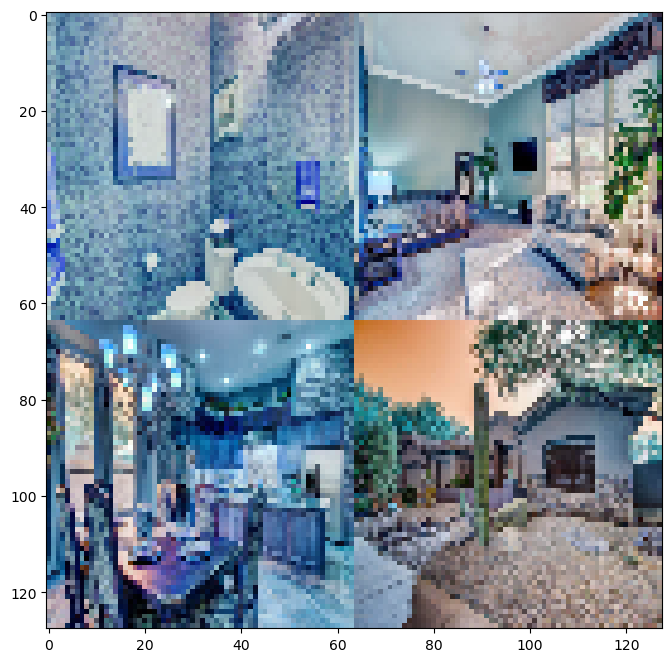

In [10]:
from matplotlib import pyplot as plt

for i in images_output[:1]:
     plt.figure(figsize=(8,8))
     plt.imshow(i, interpolation='nearest')
     plt.show()

### Step 9: Get our img_arry ready for model evaluation. The shape needs to be 4d array
### Nicolas Gugliemo

In [11]:
img_arr=np.asarray(images_output)
img_arr.shape

(452, 128, 128, 3)

### Step 10: Encode data
### Nicolas Gugliemo

In [12]:
NumericColumns = ['area']
CategoricalColumns = ['zipcode','Bedrooms','Bathrooms']

for i in NumericColumns:
    encode_numeric_zscore(df,i)
for i in CategoricalColumns:
    encode_text_dummy(df,i)

df.head()

,area,price,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,869500,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,865200,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,889000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,799000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,519200,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


### Step 11: Check shape and drop target col to prepare for model
### Nicolas Gugliemo

In [13]:
df.shape

(452, 63)

In [14]:
x = df.drop(['price'], axis = 1)
y = df.loc[:, ['price']] # Our price table

In [15]:
x

,area,zipcode-36372,zipcode-60002,zipcode-60016,zipcode-60046,zipcode-62025,zipcode-62034,zipcode-62088,zipcode-62214,zipcode-62234,...,Bathrooms-1.5,Bathrooms-2.0,Bathrooms-2.5,Bathrooms-3.0,Bathrooms-3.25,Bathrooms-3.5,Bathrooms-4.0,Bathrooms-4.5,Bathrooms-5.0,Bathrooms-6.0
0,1.652649,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,1.022859,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,1.537335,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
6,0.314122,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
10,2.340984,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530,-0.109878,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
531,6.516230,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
532,-0.156003,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
533,0.108331,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [16]:
y

,price
0,869500
1,865200
2,889000
6,799000
10,519200
...,...
530,399900
531,460000
532,407000
533,419000


### Step 12: Split all tables which include feature table, price table (target), and img table
### Nicolas Gugliemo

In [17]:
# df = text table
# img_arr = images table
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)

In [18]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(316, 62) (136, 62) (316, 1) (136, 1)


In [19]:
img_train, img_test = train_test_split(img_arr, test_size=0.30, random_state=42)
print(img_train.shape, img_test.shape)

(316, 128, 128, 3) (136, 128, 128, 3)


### Step 13: Define functional model. FCNN, CNN, and final FCNN models
### Nicolas Gugliemo

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 62)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 dense (Dense)                  (None, 256)          16128       ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 125, 125, 64  3136        ['input_2[0][0]']            

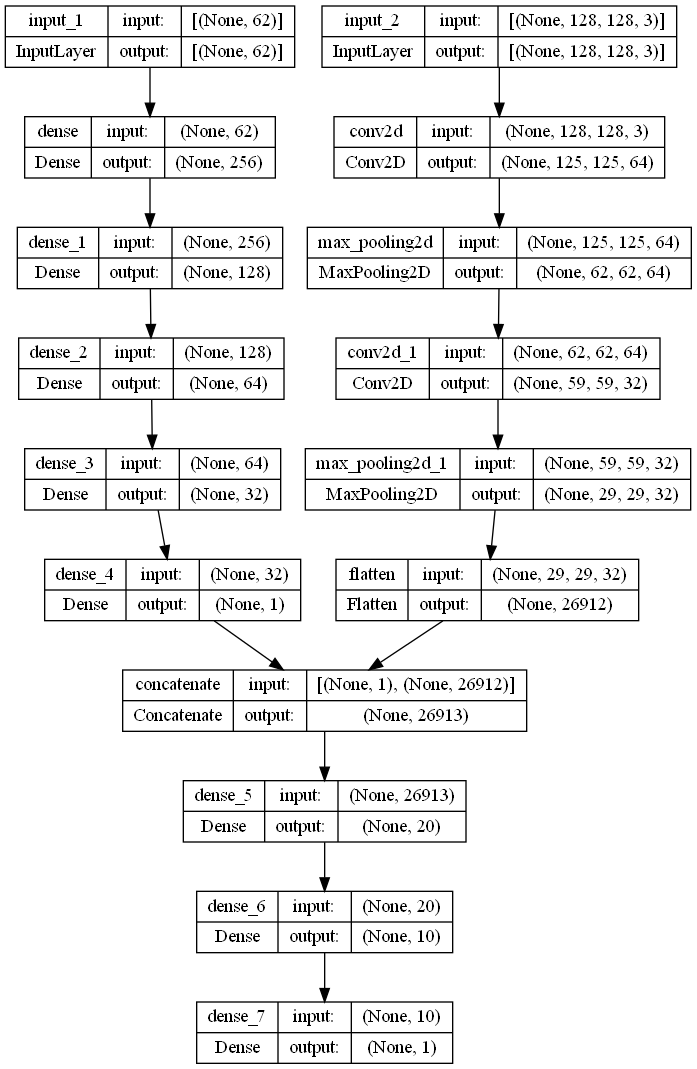

In [20]:

#FCNN for text table
input_dim = x_train.shape[1]
fcnn_input = Input(shape=(input_dim,))
fcnn_hidden1 = Dense(256, activation="relu")(fcnn_input)
fcnn_hidden2 = Dense(128, activation="relu")(fcnn_hidden1)
fcnn_hidden3 = Dense(64, activation="relu")(fcnn_hidden2)
fcnn_hidden4 = Dense(32, activation="relu")(fcnn_hidden3)
fcnn_output = Dense(1, activation="relu")(fcnn_hidden4)

#CNN for pic table
cnn_input = Input(shape=(128, 128, 3)) 
cnn_conv1 = Conv2D(64, kernel_size=4, activation='relu')(cnn_input) 
cnn_pool1 = MaxPooling2D(pool_size=(2, 2))(cnn_conv1)
cnn_conv2 = Conv2D(32, kernel_size=4, activation='relu')(cnn_pool1) 
cnn_pool2 = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
cnn_flat = Flatten()(cnn_pool2)

# merge input models
combined = concatenate([fcnn_output, cnn_flat])

#Interpret Model after concat
hidden1 = Dense(20, activation='relu')(combined)
#hidden1 = Dropout(0.2)(hidden1) 
hidden2 = Dense(10, activation='relu')(hidden1)
#hidden2 = Dropout(0.2)(hidden2)
final_output = Dense(1, activation='relu')(hidden2)

model = Model(inputs=[fcnn_input, cnn_input], outputs=final_output)

# summarize layers
print(model.summary())

# plot model
plot_model(model,show_shapes=True)


## Step 14: Strange datatype error will sometimes occur. Fix this by ensuring correct data type
### Nicolas Gugliemo 

In [21]:
x_train = np.array(x_train, dtype=np.float32)
#img_train = np.array(img_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
#img_test = np.array(img_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


## Step 15: Train and save the model
### Nicolas Gugliemo 

In [22]:
for i in range(2):
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=10, verbose=1, mode='auto')
    model.fit([x_train, img_train], y_train,batch_size=32,validation_data=([x_test, img_test], y_test),callbacks=[monitor],verbose=2,epochs=1000)
model.save("models/model.keras")

Epoch 1/1000
10/10 - 3s - loss: 238820900864.0000 - val_loss: 207606808576.0000 - 3s/epoch - 329ms/step
Epoch 2/1000
10/10 - 2s - loss: 106114670592.0000 - val_loss: 78082146304.0000 - 2s/epoch - 199ms/step
Epoch 3/1000
10/10 - 2s - loss: 62872715264.0000 - val_loss: 73486499840.0000 - 2s/epoch - 201ms/step
Epoch 4/1000
10/10 - 2s - loss: 61657468928.0000 - val_loss: 57380544512.0000 - 2s/epoch - 210ms/step
Epoch 5/1000
10/10 - 2s - loss: 55516307456.0000 - val_loss: 60640432128.0000 - 2s/epoch - 226ms/step
Epoch 6/1000
10/10 - 2s - loss: 54954369024.0000 - val_loss: 55966924800.0000 - 2s/epoch - 201ms/step
Epoch 7/1000
10/10 - 2s - loss: 53986422784.0000 - val_loss: 57632604160.0000 - 2s/epoch - 208ms/step
Epoch 8/1000
10/10 - 2s - loss: 54370549760.0000 - val_loss: 56574783488.0000 - 2s/epoch - 215ms/step
Epoch 9/1000
10/10 - 2s - loss: 54543896576.0000 - val_loss: 57649242112.0000 - 2s/epoch - 230ms/step
Epoch 10/1000
10/10 - 2s - loss: 55498526720.0000 - val_loss: 56080191488.0000 

### Step 16: Plot the results
### Nicolas Gugliemo

In [23]:
pred = model.predict([x_test,img_test])
score = np.sqrt(metrics.mean_squared_error(y_test,pred)) 

print("RMSE: {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

5/5 [==============================] - 1s 57ms/step
RMSE: 138798.3125
R2: 0.6702357145318487
MSE: 19264970000.0


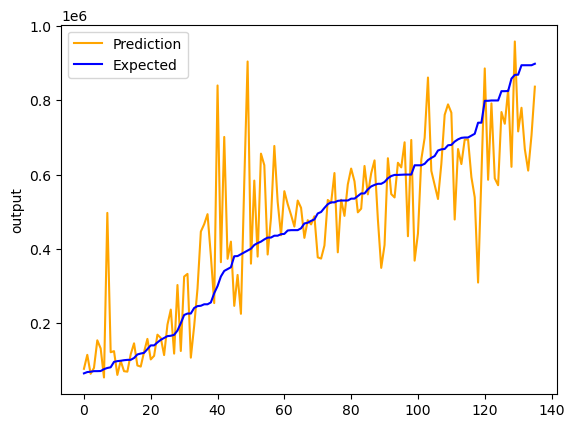

In [24]:
model_pred = np.asarray(pred)
y_test_pred = np.asarray(y_test)

chart_regression(model_pred.flatten(),y_test_pred)